# Trabalho 2 - NARMAX

EELT7016 - Séries Temporais

Autores:

- Ana Paula da Silva Pelegrini
- Caio Phillipe Mizerkowski
- Gabriel Protzek

Código:

[Colab](https://colab.research.google.com/drive/1-DNlRQ_WW8fOKJt3ncNyhaTaG7Gt2yER?usp=sharing#scrollTo=wGu64aAEvXt0)

## Introdução

Este trabalho realizado para a disciplina EELT7016 tem o objetivo de identificar três sistemas dinâmicos com comportamento não-linear usando modelo NARMAX. Busca-se avaliar o MSE (Mean Squared Error) para obter o melhor modelo e verificar o desempenho para diferentes valores de ny, nu, ne e nl.

Foram utilizadas 70% das amostras para o treinamento dos modelos e 30% para validação do mesmo.

As principais bibliotecas utilizadas neste trabalho foram: Numpy, Pandas, Matplotlib, Seaborn e Sysidentpy.

## Importações


In [ ]:
!pip install sysidentpy
!pip install matplotlib==3.1.3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

## Pré processamento dos dados


In [ ]:
from google.colab import drive

drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import scipy.io

data1 = scipy.io.loadmat("/content/drive/MyDrive/Tank1.mat")
u1 = data1["u"].reshape(-1, 1)
y1 = data1["y"][0].reshape(-1, 1)

data2 = scipy.io.loadmat("/content/drive/MyDrive/DATA_EMPS.mat")
u2 = data2["vir"].reshape(-1, 1)
y2 = data2["qm"].reshape(-1, 1)

data3 = scipy.io.loadmat("/content/drive/MyDrive/Tank2.mat")
u3 = data3["u"].reshape(-1, 1)
y3 = data3["y"][0].reshape(-1, 1)


## Narmax Model


In [ ]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.display_results import results

from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.utils.narmax_tools import regressor_code
import torch


In [ ]:
device = "cpu"


### Sinal 1


In [ ]:
n_cols = u1.shape[0]
p = 0.7
x_train, y_train = u1[int(n_cols * p) :].reshape(-1, 1), y1[int(n_cols * p) :].reshape(
    -1, 1
)
x_valid, y_valid = u1[: int(n_cols * p)].reshape(-1, 1), y1[: int(n_cols * p)].reshape(
    -1, 1
)


In [ ]:
basis_function = Polynomial(degree=4)

model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=3,
    xlag=5,
    elag=2,
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)
model.fit(X=x_train, y=y_train)


In [ ]:
yhat = model.predict(X=x_train, y=y_train)
mse = mean_squared_error(y_train, yhat)
print(f"MSE do treinamento: {mse}")
yhat = model.predict(X=x_valid, y=y_valid)
mse = mean_squared_error(y_valid, yhat)
print(f"MSE da validação: {mse}")
pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=5,
        dtype="dec",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)


MSE do treinamento: 0.070900932535296
MSE da validação: 0.13287020030174096


,Regressors,Parameters,ERR
0,y(k-1),1.5549,0.99970
1,y(k-2),-0.3493,0.00028
2,x1(k-1),0.0255,0.00000
3,y(k-1)^2,0.0044,0.00000
4,x1(k-4)x1(k-1),-0.0141,0.00000
5,x1(k-4)^3,0.0024,0.00000
6,y(k-3),-0.2300,0.00000
7,x1(k-2),0.0259,0.00000
8,y(k-3)^3,-0.0003,0.00000
9,x1(k-2)^2y(k-1),-0.0007,0.00000


Após isso, foi realizado o ranqueamento do melhor modelo testado comparando o MSE de treinamento e o MSE de validação testados, considerando a quantidade de coeficientes igual a 10 e variando os parametros nl, ny, nu e ne.

|           Modelo            | MSE de treinamento | MSE de validação |
| :-------------------------: | :----------------: | :--------------: |
| ny= 3, nu= 5, ne= 2 e nl= 4 |       0.0709       |      0.1328      |
| ny= 2, nu= 2, ne= 3 e nl= 3 |       0.0691       |      0.1906      |
| ny= 3, nu= 3, ne= 3 e nl= 4 |       0.0985       |      0.3444      |
| ny= 3, nu= 2, ne= 4 e nl= 4 |       0.0992       |      0.3564      |
| ny= 3, nu= 2, ne= 3 e nl= 3 |       0.0995       |      0.3601      |

Por fim, foi plotado o melhor resultado encontrado.


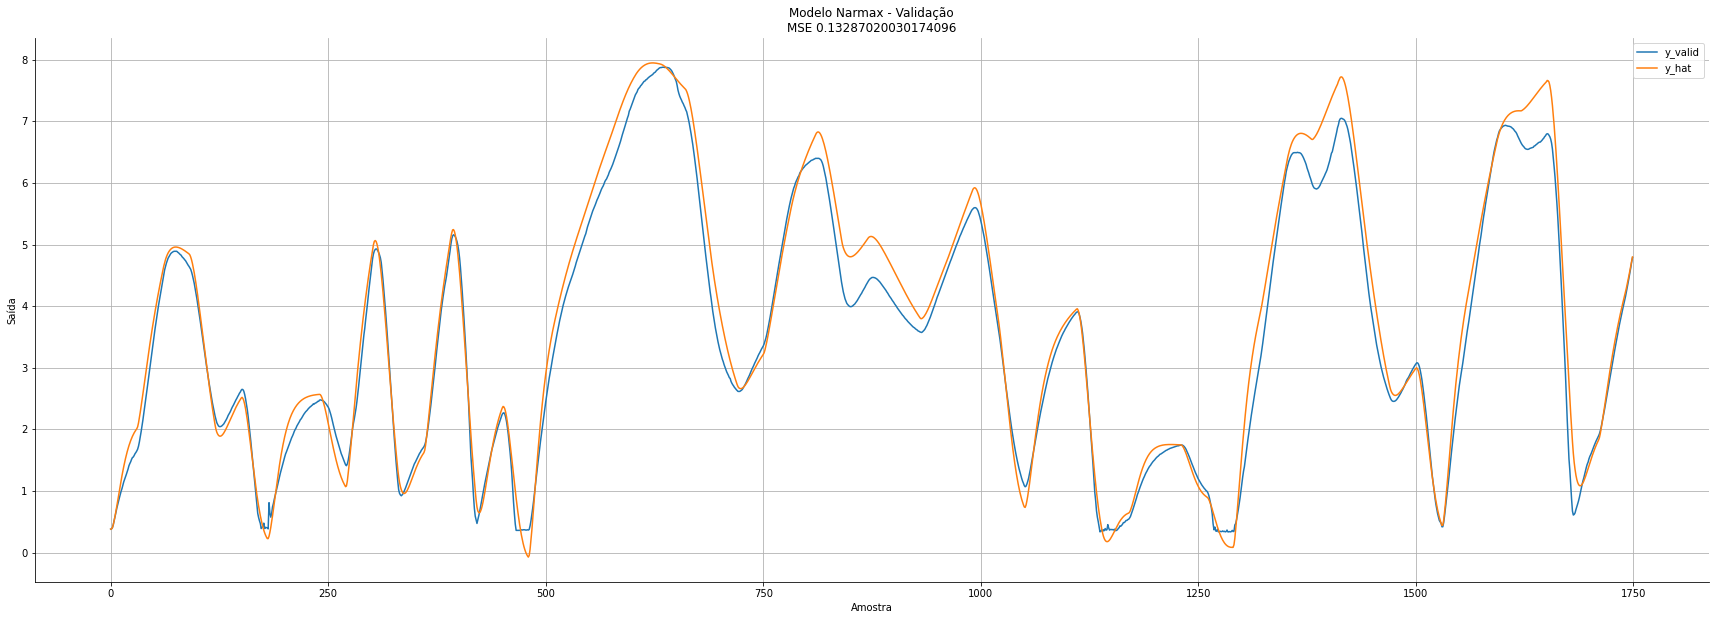

In [ ]:
mse = mean_squared_error(y_valid, yhat)
plt.figure(figsize=(30, 10))
t = np.arange(y_valid.size)
sns.lineplot(x=t, y=y_valid.flatten(), label="y_valid")
sns.lineplot(x=t, y=yhat.flatten(), label="y_hat")
plt.title(f"Modelo Narmax - Validação\nMSE {mse}")
plt.xlabel("Amostra")
plt.ylabel("Saída")

plt.grid()
plt.show()
plt.close()


### Rede neural (estrutura NARX) - Sinal 1:


In [ ]:
mean_x = np.mean(x_train)
std_x = np.std(x_train)
x_train = (x_train - mean_x) / std_x
x_valid = (x_valid - mean_x) / std_x

mean_y = np.mean(y_train)
std_y = np.std(y_train)
y_train = (y_train - mean_y) / std_y
y_valid = (y_valid - mean_y) / std_y


In [ ]:
basis_function = Polynomial(degree=3)

narx_net = NARXNN(
    ylag=2,
    xlag=2,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="SGD",
    epochs=5000,
    verbose=False,
    device="cpu",
    optim_params={}
    #     # 'betas': (0.9, 0.999),
    #     'eps': 1e-04
    #     } # optional parameters of the optimizer
)

# basis_function = Polynomial(degree=1)

regressors = regressor_code(
    X=x_train,
    ylag=2,
    xlag=2,
    model_type="NARMAX",
    model_representation="neural_network",
    basis_function=basis_function,
)
n_features = regressors.shape[0]  # the number of features of the NARX net n_features


In [ ]:
# Building the NARX Neural Network


class NARX(nn.Module):
    def __init__(self):
        super().__init__()

        self.lin = nn.Linear(n_features, 16)
        self.lin2 = nn.Linear(16, 16)
        self.lin3 = nn.Linear(16, 1)

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)

        return z


In [ ]:
narx_net.net = NARX()

narx_net.net.to(torch.device("cpu"))


NARX(
  (lin): Linear(in_features=34, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=1, bias=True)
  (tanh): Tanh()
  (relu): ReLU()
)

In [ ]:
# Fit and Predict

narx_net.fit(X=x_train, y=y_train, X_test=x_valid, y_test=y_valid)


In [ ]:
yhat = narx_net.predict(X=x_valid, y=y_valid)


MSE:  0.7063190964809734


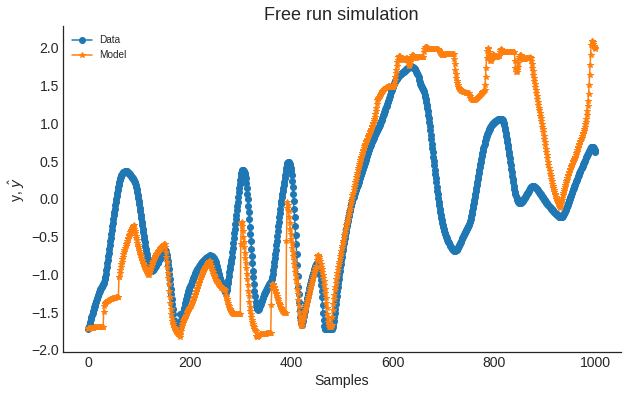

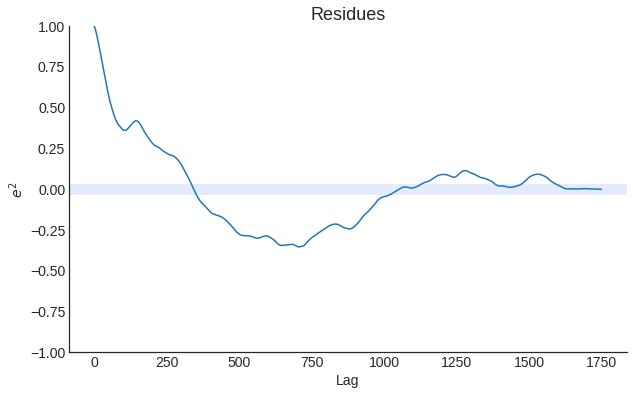

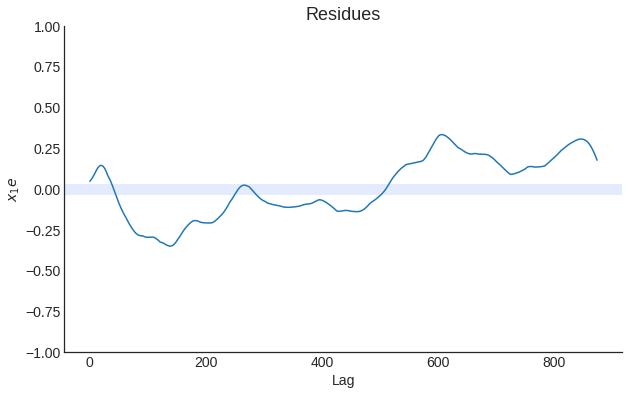

In [ ]:
# Results
print("MSE: ", mean_squared_error(y_valid, yhat))
plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")


Comparando o resultado obtido do modelo NARMAX com a rede neural (estrutura NARX) do SysIdentPy é possível obervar que o MSE do primeiro é de menor ordem obtendo um melhor desempenho. Além disso, o modelo com a rede neural exige mais processamento e maior tempo para execução dos comandos e ainda obtem um resultado inferior. No Sinal 1 o melhor modelo NARMAX testado obteve um MSE de 0.0436 enquanto o melhor MSE gerado pelo modelo com a rede neural NARX foi de 0.7063.


### Sinal 2


In [ ]:
n_cols = u2.shape[0]
p = 0.7
x_train, y_train = u2[int(n_cols * p) :].reshape(-1, 1), y2[int(n_cols * p) :].reshape(
    -1, 1
)
x_valid, y_valid = u2[: int(n_cols * p)].reshape(-1, 1), y2[: int(n_cols * p)].reshape(
    -1, 1
)


In [ ]:
basis_function = Polynomial(degree=4)

model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=2,
    xlag=1,
    elag=1,
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)
model.fit(X=x_train, y=y_train)


In [ ]:
yhat = model.predict(X=x_train, y=y_train)
mse = mean_squared_error(y_train, yhat)
print(f"MSE do treinamento: {mse}")
yhat = model.predict(X=x_valid, y=y_valid)
mse = mean_squared_error(y_valid, yhat)
print(f"MSE da validação: {mse}")
pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=5,
        dtype="dec",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)


MSE do treinamento: 2.8328058637318373e-05
MSE da validação: 0.0004660625991686272


Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x7fa61e711e60>
Traceback (most recent call last):
  File "/usr/lib/python3.7/weakref.py", line 109, in remove
    def remove(wr, selfref=ref(self), _atomic_removal=_remove_dead_weakref):
KeyboardInterrupt


,Regressors,Parameters,ERR
0,y(k-1),1.9950,1.00000
1,y(k-2),-0.9950,0.00000
2,x1(k-1),0.0000,0.00000
3,1,0.0000,0.00000
4,x1(k-1)^3,-0.0000,0.00000
5,x1(k-1)y(k-2)^3,31.2178,0.00000
6,x1(k-1)y(k-1),0.0000,0.00000
7,x1(k-1)y(k-1)^3,15.6110,0.00000
8,x1(k-1)y(k-2)^2y(k-1),-46.8289,0.00000
9,x1(k-1)y(k-1)^2,-0.0000,0.00000


Após isso, foi realizado o ranqueamento do melhor modelo testado comparando o MSE de treinamento e o MSE de validação testados, considerando a quantidade de coeficientes igual a 10 e variando os parametros nl, ny, nu e ne.

|           Modelo            | MSE de treinamento | MSE de validação |
| :-------------------------: | :----------------: | :--------------: |
| ny= 2, nu= 1, ne= 1 e nl= 4 |     2.8328e-05     |     0.000466     |
| ny= 2, nu= 1, ne= 3 e nl= 3 |     5.3824e-05     |     0.000905     |
| ny= 2, nu= 1, ne= 1 e nl= 2 |     0.0001041      |     0.000950     |
| ny= 3, nu= 1, ne= 4 e nl= 3 |     5.7481e-05     |     0.00142      |
| ny= 6, nu= 6, ne= 6 e nl= 3 |     3.2332e-05     |     0.00116      |

Por fim, foi plotado o melhor resultado encontrado.


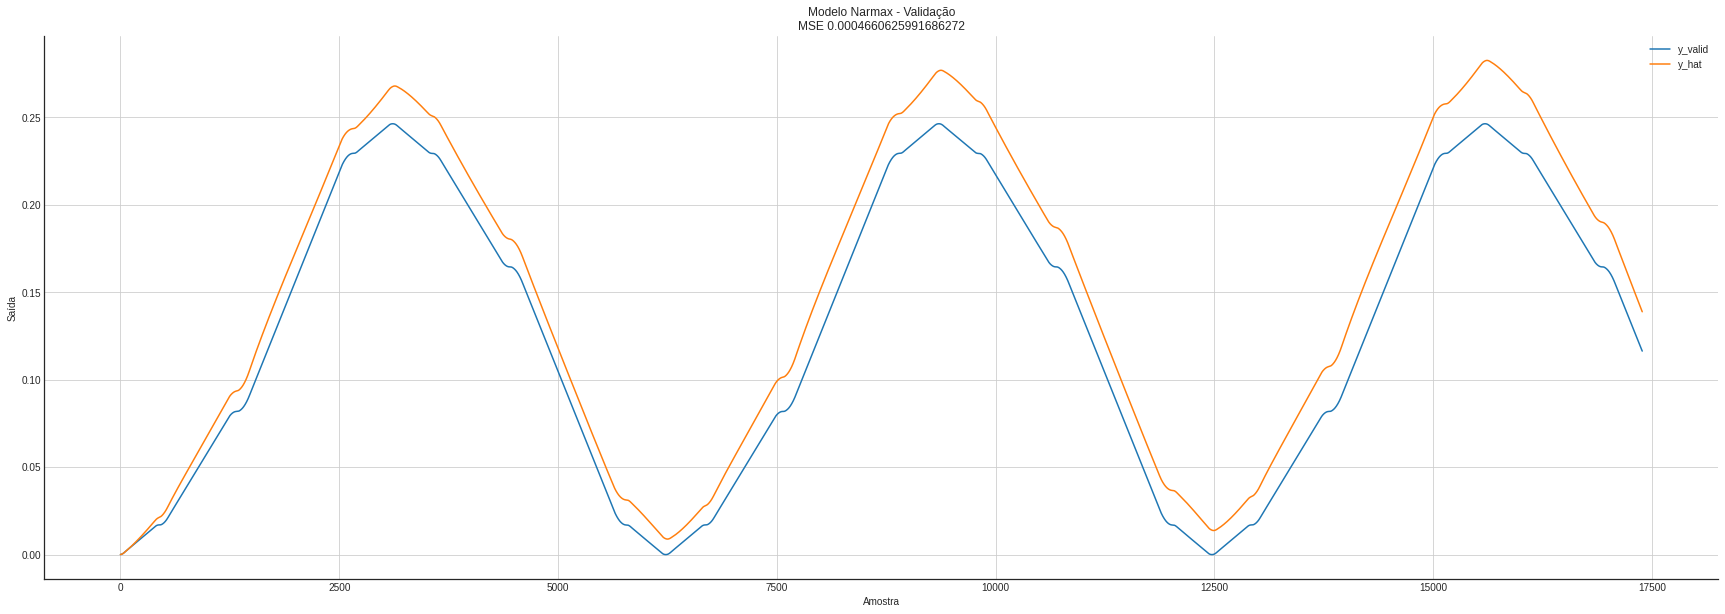

In [ ]:
mse = mean_squared_error(y_valid, yhat)
plt.figure(figsize=(30, 10))
t = np.arange(y_valid.size)
sns.lineplot(x=t, y=y_valid.flatten(), label="y_valid")
sns.lineplot(x=t, y=yhat.flatten(), label="y_hat")
plt.title(f"Modelo Narmax - Validação\nMSE {mse}")
plt.xlabel("Amostra")
plt.ylabel("Saída")

plt.grid()
plt.show()
plt.close()


### Rede neural (estrutura NARX) - Sinal 2:


In [ ]:
mean_x = np.mean(x_train)
std_x = np.std(x_train)
x_train = (x_train - mean_x) / std_x
x_valid = (x_valid - mean_x) / std_x

mean_y = np.mean(y_train)
std_y = np.std(y_train)
y_train = (y_train - mean_y) / std_y
y_valid = (y_valid - mean_y) / std_y


In [ ]:
basis_function = Polynomial(degree=4)

narx_net = NARXNN(
    ylag=2,
    xlag=1,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="ASGD",
    epochs=5000,
    verbose=False,
    device="cpu",
    optim_params={}
    #     # 'betas': (0.9, 0.999),
    #     'eps': 1e-04
    #     } # optional parameters of the optimizer
)

# basis_function = Polynomial(degree=1)

regressors = regressor_code(
    X=x_train,
    ylag=2,
    xlag=1,
    model_type="NARMAX",
    model_representation="neural_network",
    basis_function=basis_function,
)
n_features = regressors.shape[0]  # the number of features of the NARX net n_features


In [ ]:
# Building the NARX Neural Network


class NARX(nn.Module):
    def __init__(self):
        super().__init__()

        self.lin = nn.Linear(n_features, 16)
        self.lin2 = nn.Linear(16, 16)
        self.lin3 = nn.Linear(16, 1)

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)

        return z


In [ ]:
narx_net.net = NARX()

narx_net.net.to(torch.device("cpu"))


NARX(
  (lin): Linear(in_features=34, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=1, bias=True)
  (tanh): Tanh()
  (relu): ReLU()
)

In [ ]:
# Fit and Predict

narx_net.fit(X=x_train, y=y_train, X_test=x_valid, y_test=y_valid)


In [ ]:
yhat = narx_net.predict(X=x_valid, y=y_valid)


MSE:  0.7413824419524857


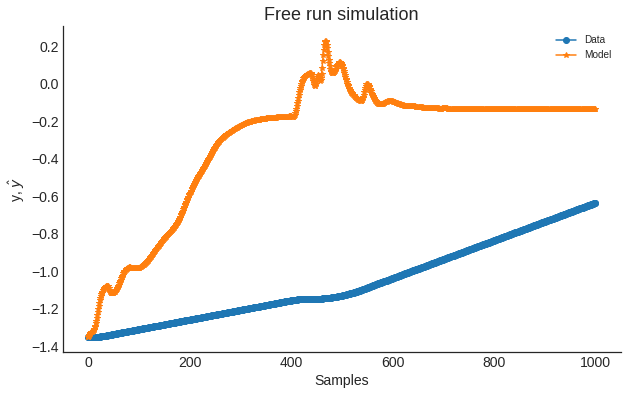

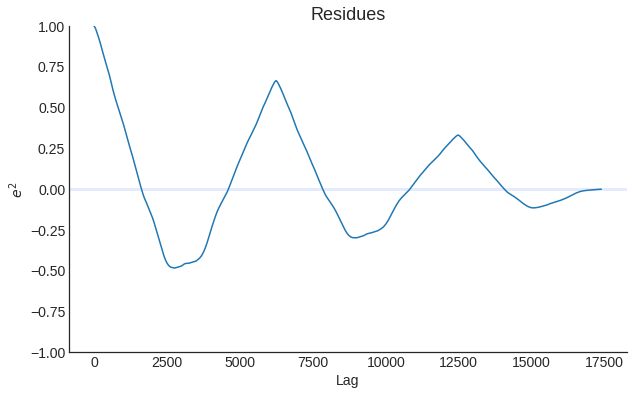

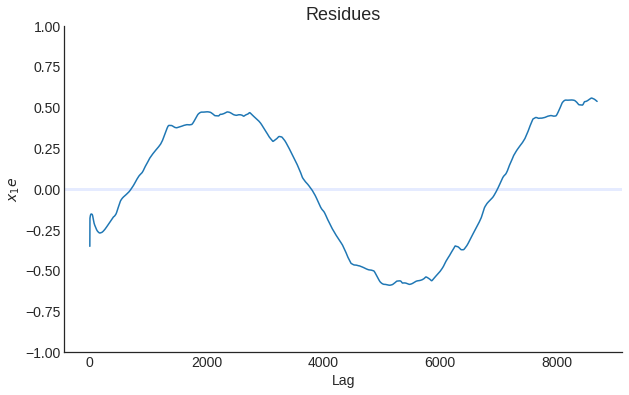

In [ ]:
# Results
print("MSE: ", mean_squared_error(y_valid, yhat))
plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")


Para o Sinal 2 é possível observar a mesma situação que para o Sinal 1. O modelo NARMAX gerado é mais eficiente e tem um melhor valor de MSE que o modelo gerado pela rede neural.


### Sinal 3


In [ ]:
n_cols = u3.shape[0]
p = 0.7
x_train, y_train = u3[int(n_cols * p) :].reshape(-1, 1), y3[int(n_cols * p) :].reshape(
    -1, 1
)
x_valid, y_valid = u3[: int(n_cols * p)].reshape(-1, 1), y3[: int(n_cols * p)].reshape(
    -1, 1
)


In [ ]:
basis_function = Polynomial(degree=3)

model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=3,
    xlag=2,
    elag=3,
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)
model.fit(X=x_train, y=y_train)


In [ ]:
yhat = model.predict(X=x_train, y=y_train)
mse = mean_squared_error(y_train, yhat)
print(f"MSE do treinamento: {mse}")
yhat = model.predict(X=x_valid, y=y_valid)
mse = mean_squared_error(y_valid, yhat)
print(f"MSE da validação: {mse}")
pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=5,
        dtype="dec",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)


MSE do treinamento: 0.02838845950167195
MSE da validação: 0.020925926697683866


,Regressors,Parameters,ERR
0,y(k-1),1.8697,0.99981
1,y(k-2),-0.8795,0.00018
2,x1(k-1),0.0217,0.00000
3,y(k-1)^3,-0.3764,0.00000
4,x1(k-1)^2,-0.0070,0.00000
5,x1(k-2)^3,0.0012,0.00000
6,y(k-3)^3,0.3364,0.00000
7,y(k-2)y(k-1)^2,0.5546,0.00000
8,y(k-3)^2y(k-2),-0.5147,0.00000
9,y(k-1)^2,0.0018,0.00000


Após isso, foi realizado o ranqueamento do melhor modelo testado comparando o MSE de treinamento e o MSE de validação testados, considerando a quantidade de coeficientes igual a 10 e variando os parametros nl, ny, nu e ne.

|           Modelo            | MSE de treinamento | MSE de validação |
| :-------------------------: | :----------------: | :--------------: |
| ny= 3, nu= 2, ne= 3 e nl= 3 |      0.02838       |     0.02092      |
| ny= 2, nu= 2, ne= 2 e nl= 5 |      0.02691       |     0.02531      |
| ny= 2, nu= 2, ne= 2 e nl= 3 |      0.02574       |     0.04362      |
| ny= 4, nu= 4, ne= 3 e nl= 4 |      0.03784       |     0.05439      |
| ny= 3, nu= 4, ne= 4 e nl= 5 |      0.03753       |     0.06645      |

Por fim, foi plotado o melhor resultado encontrado.


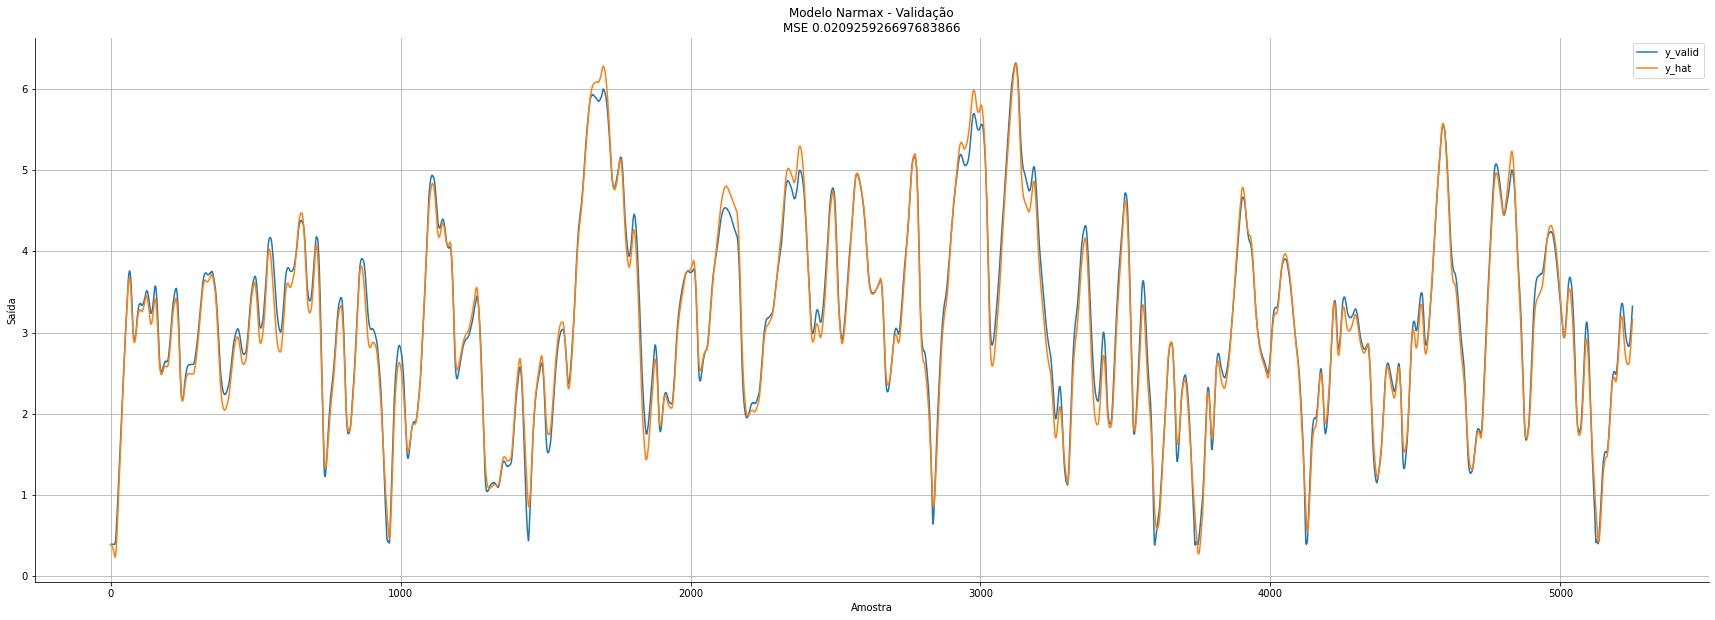

In [ ]:
mse = mean_squared_error(y_valid, yhat)
plt.figure(figsize=(30, 10))
t = np.arange(y_valid.size)
sns.lineplot(x=t, y=y_valid.flatten(), label="y_valid")
sns.lineplot(x=t, y=yhat.flatten(), label="y_hat")
plt.title(f"Modelo Narmax - Validação\nMSE {mse}")
plt.xlabel("Amostra")
plt.ylabel("Saída")

plt.grid()
plt.show()
plt.close()


### Rede neural (estrutura NARX) - Sinal 3:


In [ ]:
mean_x = np.mean(x_train)
std_x = np.std(x_train)
x_train = (x_train - mean_x) / std_x
x_valid = (x_valid - mean_x) / std_x

mean_y = np.mean(y_train)
std_y = np.std(y_train)
y_train = (y_train - mean_y) / std_y
y_valid = (y_valid - mean_y) / std_y


In [ ]:
# https://pytorch.org/docs/stable/optim.html#algorithms

basis_function = Polynomial(degree=3)

narx_net = NARXNN(
    ylag=3,
    xlag=2,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="SGD",
    epochs=5000,
    verbose=False,
    device="cpu",
    optim_params={}
    #     # 'betas': (0.9, 0.999),
    #     'eps': 1e-04
    #     } # optional parameters of the optimizer
)

# basis_function = Polynomial(degree=1)

regressors = regressor_code(
    X=x_train,
    ylag=3,
    xlag=2,
    model_type="NARMAX",
    model_representation="neural_network",
    basis_function=basis_function,
)
n_features = regressors.shape[0]  # the number of features of the NARX net n_features


In [ ]:
# Building the NARX Neural Network


class NARX(nn.Module):
    def __init__(self):
        super().__init__()

        self.lin = nn.Linear(n_features, 16)
        self.lin2 = nn.Linear(16, 16)
        self.lin3 = nn.Linear(16, 1)

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)

        return z


In [ ]:
narx_net.net = NARX()

narx_net.net.to(torch.device("cpu"))


NARX(
  (lin): Linear(in_features=55, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=1, bias=True)
  (tanh): Tanh()
  (relu): ReLU()
)

In [ ]:
# Fit and Predict

narx_net.fit(X=x_train, y=y_train, X_test=x_valid, y_test=y_valid)


In [ ]:
yhat = narx_net.predict(X=x_valid, y=y_valid)


MSE:  1.369596298150856


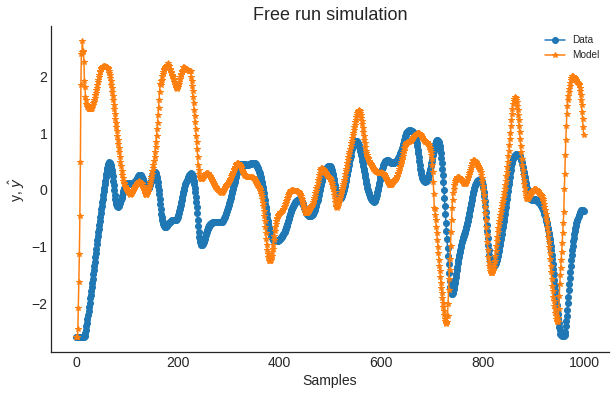

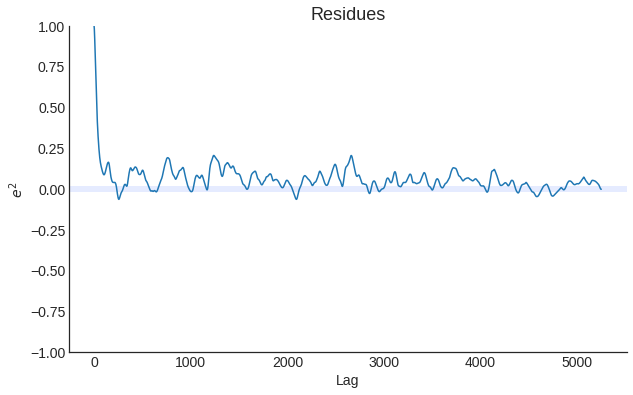

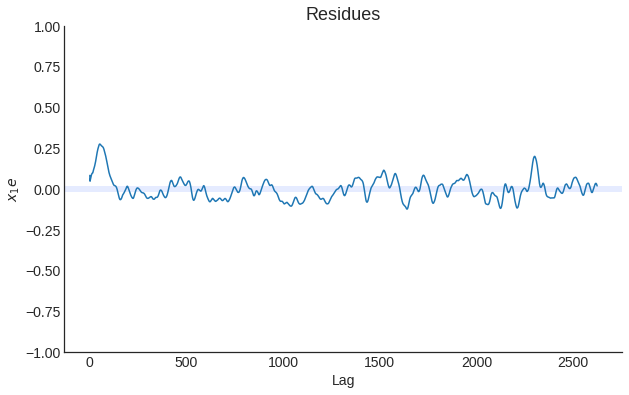

In [ ]:
# Results
print("MSE: ", mean_squared_error(y_valid, yhat))
plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")


Por fim, para o Sinal 3, foi observado o mesmo comportamento que para o Sinal 1 e 2. O modelo NARMAX gerado foi mais eficiente e com melhor fit - MSE que o modelo gerado pela rede neural (estrutura NARX) do SysIdentPy. O modelo NARMAX obteve um MSE de 0.02092 enquanto o modelo de rede neural com NARX 1.3695.
